# Supervised Model
Classification with  Random Forest

In [ ]:
# Install dependencies as needed:
# !pip install "kagglehub[pandas-datasets]" scikit-learn

import kagglehub
from kagglehub import KaggleDatasetAdapter

# exercise_random_forest_heart.py (sem scipy)
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix,  ConfusionMatrixDisplay, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1. Load Data

In [2]:
file_path = "heart_cleveland_upload.csv"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "cherngs/heart-disease-cleveland-uci",  
    file_path,                              
)

print("First 5 records:")
print(df.head())

/var/folders/bp/4bp0nhvd3zd55p3lw4rlzq3w0000gn/T/ipykernel_86230/1091370593.py:3: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   69    1   0       160   234    1        2      131      0      0.1      1   
1   69    0   0       140   239    0        0      151      0      1.8      0   
2   66    0   0       150   226    0        0      114      0      2.6      2   
3   65    1   0       138   282    1        2      174      0      1.4      1   
4   64    1   0       110   211    0        2      144      1      1.8      1   

   ca  thal  condition  
0   1     0          0  
1   2     0          0  
2   0     0          0  
3   1     0          1  
4   0     0          0  


In [3]:
print("Columns:", df.columns.tolist())
print(df.head(1))

Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'condition']
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   69    1   0       160   234    1        2      131      0      0.1      1   

   ca  thal  condition  
0   1     0          0  


# Fields Describe to Understanding the data 

| Column     | Variable name (full description)        | Description                                                                 | Variable type        | Indicator for… |
|-----------|------------------------------------------|-----------------------------------------------------------------------------|----------------------|----------------|
| age       | Age                                      | Patient age in years                                                        | Continuous numeric   | Cardiovascular risk associated with aging |
| sex       | Biological sex                            | 0 = female, 1 = male                                                        | Binary               | Sex-related differences in cardiovascular risk |
| cp        | Chest pain type                          | 1: typical angina, 2: atypical angina, 3: non-anginal pain, 4: asymptomatic | Categorical          | Type and severity of clinical manifestation |
| trestbps | Resting blood pressure                   | Resting blood pressure measured at hospital admission (mm Hg)              | Continuous numeric   | Hypertension |
| chol     | Serum cholesterol                        | Total serum cholesterol (mg/dL)                                             | Continuous numeric   | Atherosclerotic risk |
| fbs      | Fasting blood sugar                      | >120 mg/dL = 1, ≤120 mg/dL = 0                                              | Binary               | Hyperglycemia / diabetes |
| restecg  | Resting electrocardiographic results     | 0: normal, 1: ST-T abnormality, 2: left ventricular hypertrophy             | Categorical          | Cardiac electrical abnormalities |
| thalach  | Maximum heart rate achieved              | Maximum heart rate achieved during exercise test (bpm)                      | Continuous numeric   | Functional capacity and exercise response |
| exang    | Exercise-induced angina                  | 1 = yes, 0 = no                                                             | Binary               | Exercise-induced ischemia |
| oldpeak  | ST segment depression                   | ST depression induced by exercise relative to rest                          | Continuous numeric   | Severity of myocardial ischemia |
| slope    | Slope of the ST segment                  | 1: upsloping, 2: flat, 3: downsloping                                       | Categorical          | Prognostic response to exercise |
| ca       | Number of major vessels                  | Number of major coronary vessels visualized by fluoroscopy (0–3)            | Ordinal              | Extent of coronary artery disease |
| thal     | Thallium stress test result              | 3: normal, 6: fixed defect, 7: reversible defect                            | Categorical          | Myocardial perfusion |
| condition| Presence of heart disease (target)       | 0 = absence of heart disease, 1 = presence                                  | Binary (Target)      | Heart disease diagnosis |


# 2. Define categorical and numerical variables based on the description.

In [4]:
# Just for learning goal:
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']

# 3. Remove outliers based on IQR

In [5]:
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    filter = (df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)
    df = df[filter]

# 4. Split in X and Y

In [6]:
X = df[categorical_cols + numerical_cols]
y = df["condition"]

# 5. Split in train/test

In [7]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y, random_state=0 )

| Category | Models | Scaling Required |
|--------|--------|------------------|
| Distance-based | KNN, K-Means, DBSCAN, Hierarchical Clustering | ✅ Yes |
| Gradient-based | Logistic Regression, Linear Regression, SVM, Ridge, Lasso | ✅ Yes |
| Neural Networks | MLP, Deep Learning models | ✅ Yes |
| Tree-based | Decision Tree, Random Forest, Gradient Boosting, XGBoost | ❌ No |


In [8]:
# Scaling:
preprocessor = ColumnTransformer(
    transformers=[
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

pipeline = Pipeline([
    ("pre", preprocessor),
    ("clf", RandomForestClassifier(random_state=0))
])

#  7. Cross-validation

# Avoid Overfitting (Model learns too much from training data → fails on new data)
Overfitting occurs when: the model performs very well on training data but performs poorly in validation/testing

In other words: the difference between training and validation is large.

The main criterion for overfitting is: Train Accuracy ≫ CV Score Train Mean
### Strategies to avoid it:
• Separate training/testing
• Cross-validation
• Regularization

# When to suspect overfitting?
- e.g.: very different scores -> Scores: [0.92, 0.52, 0.90, 0.55, 0.91]: High variance ⇒ the model does not generalize well ⇒ possible overfitting.

or
- Training accuracy is much higher than validation accuracy: (Training accuracy: 0.99
- Average validation accuracy: 0.82) -> Very large difference ⇒ clear overfitting.

* What is a “good” accuracy? It depends on the problem:

- Common binary classification → 70%–85% is already reasonable
- Balanced and simple data → can reach 90%
- Medical problems → may require > 90%
- Complex problems → 60%–70% is already good
- There is no absolute value.

# cross_val_score() from sklearn.model_selection lib

context

Performs 5-fold cross-validation

In each fold:
- 80% of the data → training
- 20% → validation

The pipeline is reset from scratch at each iteration: (preprocessing + model)

This measures generalization capability, not inflated performance.

In [9]:
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)

print(f"the folds mean was: {cv_scores.mean():.3f} \n This mean that the model On average, the model correctly predicts 81% of cases in unseen data, before optimization. \n")

for i, v in enumerate(cv_scores):
    # each value is the accuracy of the model in each different fold (cv=5)-> 5 “mini-experiment" Each with distinct validation data.
    # More reliable than a single train/test split
    # Less subject to the luck of a split
    print(f"In fold nº={i} the accuracy was: {v:.3f}")

# context: Accuracy = (TP + TN) / (TP + TN + FP + FN)
# In other words: the percentage of correct predictions in unseen data (on average, across the 5 tests).
print(f"\n Average accuracy (before optimization - v_scores.mean()): {cv_scores.mean():.2f}")

the folds mean was: 0.814 
 This mean that the model On average, the model correctly predicts 81% of cases in unseen data, before optimization. 

In fold nº=0 the accuracy was: 0.786
In fold nº=1 the accuracy was: 0.738
In fold nº=2 the accuracy was: 0.881
In fold nº=3 the accuracy was: 0.786
In fold nº=4 the accuracy was: 0.878

 Average accuracy (before optimization - v_scores.mean()): 0.81


[update] 
The cross-validation results show an average accuracy of 0.814, indicating that the model correctly classifies approximately 81% of the cases on unseen data before hyperparameter optimization. 

The accuracy values across the five folds range from 0.738 to 0.881, suggesting moderate variability but overall stable performance, with no strong indication of overfitting. 

This result provides a solid baseline for comparison with the optimized model obtained via GridSearchCV.

# Result Context  
CV Score:
[0.785 0.738 0.880 0.785 0.878]
cv_scores -> Each value represents:
Model accuracy at a different fold

In other words:
- 5 “mini-experiments”
- Each with distinct validation data

CV Scores Mean: 0.814

this means that, on average, the model correctly predicts 85% of cases in unseen data, before optimization.

This means:
- more reliable than a single train/test split
- less subject to the luck of the split

# Result Analysis
"What is the expected average performance of this model on unseen data (estimated via CV)?"
- Answer: ~0.81 (CV Scores Mean: 0.814)
- But this does NOT detect overfitting on its own.

# To diagnose overfitting, you need two metrics from the SAME model:

- Train accuracy → memorization ability
- CV means → generalization ability

Overfitting only exists through comparison, never through a single metric in isolation.

In [22]:
pipeline.fit(X_train, y_train)

# Train Accuracy 
train_accuracy = accuracy_score(y_train, pipeline.predict(X_train))

print(f"Train accuracy (baseline): {train_accuracy:.3f}")
print(f"CV mean (baseline): {cv_scores.mean():.3f}")
print(f"Gap (Train - CV): {train_accuracy - cv_scores.mean():.3f}")


Train accuracy (baseline): 1.000
CV mean (baseline): 0.814
Gap (Train - CV): 0.186


# Context Result
### Situation Interpretation
- Train ≈ CV Healthy Model
- Train > CV (gap > 0.05–0.10) -> Overfitting
- Train = 1.00 and CV ≪ 1.00 -> Structural Overfitting


ob.:Without the precision of Train, Step 7 is incomplete.
You were only measuring generalization, not memorization.

# Result
1.000 > 0.814 = overfitting

Gap (Train - CV): 0.186 (0.186 is well above the limit.)

The baseline Random Forest model shows strong memorization capability but limited generalization, as evidenced by a large gap between training accuracy and cross-validation performance.

### context
- Acceptable gap: ≤ 0.05
- Attention gap: 0.05 – 0.10
- Critical gap: > 0.10


# 8. Optimizing with GridSearchCV
### Round 1

In [25]:
param_grid = {
"clf__n_estimators": [50, 100],
"clf__max_depth": [None, 10, 20]
}

grid = GridSearchCV(pipeline, param_grid, cv=5)
grid.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...om_state=0))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'clf__max_depth': [None, 10, ...], 'clf__n_estimators': [50, 100]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displ

# Result 
Hyperparameter optimization was performed using GridSearchCV, evaluating combinations of the number of trees and maximum tree depth through 5-fold cross-validation, in order to identify the model configuration with the best generalization performance.

### Optimization was:
- max_depth: 10
- best_estimator___clf__n_estimators = 50

# 9. Model Evaluation

In [26]:
best = grid.best_estimator_

train_acc = accuracy_score(y_train, best.predict(X_train))

cv_scores = cross_val_score(best, X_train, y_train, cv=5)
cv_mean = cv_scores.mean()

print("Best params:", grid.best_params_)
print(f"Train accuracy (round 1): {train_acc:.3f}")
print("CV scores (round 1):", cv_scores)
print(f"CV mean (round 1): {cv_mean:.3f}")
print(f"Gap (Train - CV): {train_acc - cv_mean:.3f}")


Best params: {'clf__max_depth': 10, 'clf__n_estimators': 50}
Train accuracy (round 1): 1.000
CV scores (round 1): [0.80952381 0.78571429 0.9047619  0.78571429 0.87804878]
CV mean (round 1): 0.833
Gap (Train - CV): 0.167


# Fast Result
1.000 > 0.833 (Train ≫ CV → overfitting estrutural)
Gap (Train - CV): 0.167 


### Was there an improvement compared to the baseline?
- yes, partially.

#### CV means increased:
- Before: 0.814
- Now: 0.833 
then we have a better average generalization

#### Gap decreased slightly:
- Before: 0.186
- Now: 0.167 - still have higher then 0.05 (still very high)

# Result 
## Technical Diagnosis (the most important point)
- Clear indication of overfitting
### What does this reveal about the model?
Even with max_depth=10, the model:
- continues to remember the training (Train = 1000)
- still creates very specific rules
- Is structurally overfitting

GridSearch improved average performance, but did not control complexity sufficiently.


## Why:
- Metric Value
- Train accuracy 1.00
- CV mean accuracy 0.833
- Gap ~16 percentage points

## Practical rule used by experts:
- If Train accuracy ≫ CV/Test accuracy, the model is memorizing the training.


The model Random Forest is especially prone to this when:
- max_depth is high or none
- min_samples_leaf is low
- Many deep trees
this mean that although the Random Forest achieved perfect accuracy on the training set, cross-validation results indicate a significantly lower average accuracy (~81%). This discrepancy suggests that the model may be overfitting, learning patterns specific to the training data that do not fully generalize to unseen samples.

# The model is not yet acceptable for production. We need to move to round 2 with specific parameters.

# CV GridSearch
### Round 2
#### What to do (best practices recommended)

- Even before changing the model, experts would do the following:

Restrict forest complexity:

- param:
Why do these parameters help reduce overfitting?

### max_depth [5, 10, 15] (remove None)

Limits the depth of the trees.

Shallower trees "decorate" the training less → reduces Train=1.00 and increases generalization.

### min_samples_leaf [5, 10, 20]

Forces each leaf to have more examples.

Avoids super-specific rules ("if X=…, then class=…").

It is one of the most effective ways to control overfitting in trees.

### min_samples_split [10, 20]

Requires more data to split a node.

Reduces "noisy" splits and overly detailed trees.

### n_estimators [100, 200]

More trees tend to stabilize the prediction (reduce variance), but does not solve overfitting alone if the trees are deep. Here, it helps with stability, while the others control complexity.

In [27]:
param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [5, 10, 15],
    "clf__min_samples_leaf": [5, 10, 20],
    "clf__min_samples_split": [10, 20]
}

grid_round_2 = GridSearchCV(pipeline, param_grid, cv=5)
grid_round_2.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...om_state=0))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'clf__max_depth': [5, 10, ...], 'clf__min_samples_leaf': [5, 10, ...], 'clf__min_samples_split': [10, 20], 'clf__n_estimators': [100, 200]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each

# Reevaluation

### In professional reports, it is good practice to recalculate the resume using best_estimator_ to:
- ensure consistency
- have explicit metrics
- avoid methodological confusion

In [28]:
best2 = grid_round_2.best_estimator_

cv2 = cross_val_score(best2, X_train, y_train, cv=5)
train2 = accuracy_score(y_train, best2.predict(X_train))

print("CV scores (round 2):", cv2)
print("CV mean (round 2):", cv2.mean())
print(f"Train accuracy (round 2): {train2:.3f}")
print(f"Gap (Train - CVmean): {train2 - cv2.mean():.3f}")

CV scores (round 2): [0.83333333 0.80952381 0.9047619  0.78571429 0.85365854]
CV mean (round 2): 0.8373983739837397
Train accuracy (round 2): 0.871
Gap (Train − CVmean): 0.033


# 2º Round

### Technical Interpretation
1. Was overfitting controlled? Yes. Successfully. 

2. Gap 0.033 is well below the acceptable limit (≈ 0.05)

3. Train and CV are aligned: The model generalizes consistently

This indicates that the model learned real patterns, not just memorized the training (when we just check the CV accuracy without the Train accuracy).


# Final Result

After introducing structural constraints, the Random Forest model achieved a balanced trade-off between bias and variance, significantly reducing overfitting while maintaining strong predictive performance.

What changed compared to previous rounds?
|Stage |Train   |CV Mean  |Gap |Diagnosis|
|------|--------|-----|---------|---------|
|Baseline |1.000| 0.814 |0.186 |NOK:Severe overfitting|
|Round 1 |1.000 |0.833 |0.167 | NOK:Still overfitting|
|Round 2 |0.871 |0.837 |0.033|  OK:Balanced model|

- Slight drop in Train (expected)
- CV rose slightly
- **Gap plummeted** - clear sign of effective regularization

*** Train set is for model tuning 

*** Test set is to see the performance final on unseen data.

## Let's see the performance in unseen data
#### What is the final performance of the model on never-before-seen data?

Test Accuracy measures the fraction of correct predictions in the test set (data not used for training or cross-validation).

The Test is a separate, never-before-seen set of events. It is a "simulation" of the real world.

So: If the model generalizes well, the Test value tends to stay close to the CV mean.

If the Test value is much lower, it means that the performance is not sustained outside the samples used in the CV.

In [37]:
test_accuracy = accuracy_score(y_test, best2.predict(X_test))

# Is the Test ≈ CV mean?
print(f"Test accuracy (final): {test_accuracy:.3f}")
print(f"CV mean (round 2) Final Train Accuracy : {cv2.mean():.3f}")

Test accuracy (final): 0.925
CV mean (round 2) Final Train Accuracy : 0.837


# test accuracy context
## Why NOT use the Test first?

If you calculated Test accuracy before controlling for overfitting:

You would see the result
Even unconsciously, you could:
- adjust parameters
- choose models
- “decide” when to stop

This is indirect data leakage.

Even without touching the data, just looking at it influences decisions.


## The right time to use the Test Set

After:
- the model is stable (Train ≈ CV)
- the gap is controlled
- the architecture has been fixed

In other words:
- When you no longer want to change the model.
- This is exactly where you are now.

# Rule used by experts (industry + academia)

| Phase | Data Used |
| --------------------- | ---------------------- |
| Exploration | Complete Dataset |
| Model Design | Train |
| Overfitting Control | Train + CV |
| Hyperparameter Tuning | Train + CV |
| **Final Validation** | **Test (1 time only)** |


# Result context

#### Typical interpretation:

Δ=∣Test−CV mean∣

- Δ ≤ 0.02–0.03 → excelente consistência
- 0.03 < Δ ≤ 0.05–0.07 → aceitável (depende do tamanho do dataset)
- Δ > 0.07–0.10 → sinal de instabilidade / possível overfitting / dataset shift

# Expected:
-Test ≈ 0.82 – 0.86
- Close to CV mean (0.837)
If the Test confirms this, the model is validated.


# Result Analysis

The test set was evaluated only after model regularization and hyperparameter selection, ensuring an unbiased estimate of final performance.

CV mean (round 2) Final Train Accuracy : 0.837
Test accuracy (final): 0.925 

The Test Accuracy is Higher than the CV mean, so, this can happen and it's not an error. Common and acceptable reasons:

- The test split was "easier" (fewer ambiguous cases)
- The dataset is relatively small → higher variance
- The CV is a conservative estimate (average of 5 scenarios)
- The model generalizes well and the test confirmed this

Observation:

Test > CV does not indicate overfitting.
Overfitting would be Train ≫ CV (which no longer occurs).


Finally,  the model was checked and assessed:

Does this result validate the model? Yes. Clearly.

Criteria met:
- Controlled overfitting (low gap)
- Consistent CV (0.837)
- Test confirms and even exceeds CV estimate (0.925)

Then the model is robust and well generalized.

After controlling model complexity through hyperparameter tuning, the Random Forest achieved a cross-validated accuracy of 0.837 on the training data. The final test accuracy reached 0.925, confirming strong generalization performance and validating the selected model configuration

Last context in summary:

Why don't we compare Test with Train directly?
Because they answer different questions:
- Train → "Did the model memorize?"
- CV → "Does the model generalize?"
- Test → "Is this generalization confirmed on truly new data?"

The correct flow is:

- Controlling overfitting with Train vs CV
- Then, confirm with Test.

# Let to analyze the model classes 

It only makes sense to analyze the confusion matrix when the model is already stabilized.

Why not use it multiple times?

Because:
- It depends on the test set.
- The test set is unique and non-renewable.

## When to use it more than once (exception)?

Only if:
- you change the model's objective
(e.g., minimizing FN instead of maximizing accuracy)
- or change the decision limit (in probabilistic models)

Even then:
- the model doesn't change
- only the interpretation of the error changes


# Let's analyze the classes of the model.

It only makes sense to analyze the confusion matrix when the model is already stabilized.

Why not use it multiple times?

Because:
- It depends on the test set.
- The test set is unique and non-renewable.

## When to use it more than once (exception)?

Only if:
- you change the model's objective
(e.g., minimizing FN instead of maximizing accuracy)
- or change the decision limit (in probabilistic models)

Even then:
- the model doesn't change
- only the interpretation of the error changes


In [40]:
# The confusion matrix was evaluated only on the final test set 
# to analyze class-specific errors after model optimization.
# Never calculate the confusion matrix with:
### Baseline model,
##### Intermediate models,
##### Models before overfitting control.

# The confusion matrix is ​​a final analysis, and you should always use the definitive best estimator.
cm = confusion_matrix(y_test, best2.predict(X_test))
print("Confusion Matrix: \n", cm)


Confusion Matrix: 
 [[31  0]
 [ 4 18]]


# Result Analysis

The model generalizes well, does not overfiting, and is highly accurate in identifying healthy individuals, but still misses some cases of disease, making class 1 the most difficult to classify.



- TN = 31 → 31 healthy individuals correctly classified
- FP = 0 → no healthy individuals were classified as ill
- FN = 4 → 4 patients were classified as healthy
- TP = 18 → 18 patients correctly classified
then the model is extremely conservative for the healthy class
zero false positives (no false alarms).

The most difficult class to classify is class 1 (patient).
there are false negatives (real cases of disease that the model did not detect).

Important Practical Implication

In a clinical context:
- FN (4 cases) are more critical than FP.
- The model prioritizes specificity (avoiding false alarms) over sensitivity.


# Let's see in the graphic

While the confusion matrix answers “where did the model go wrong?”

the classification report answers “how well does it classify each class?”.

in summary:
For each class (0 and 1):

🔹 Precision

Of the cases that the model predicted as belonging to that class, how many were correct?

High precision → few false alarms (low FP)

Recall (Sensitivity)

Of the real cases in that class, how many did the model manage to identify?

Low recall → many missed cases (high FN)

F1-score

Balance between precision and recall

Useful when there is a trade-off between FP and FN

Support

Number of real examples of that class in the test set

The classification report confirms that the model performs excellently overall, with high accuracy for the healthy class and good recall for the sick class, although the latter still represents the greatest classification challenge.


 Classification Report: 
               precision    recall  f1-score   support

           0       0.89      1.00      0.94        31
           1       1.00      0.82      0.90        22

    accuracy                           0.92        53
   macro avg       0.94      0.91      0.92        53
weighted avg       0.93      0.92      0.92        53



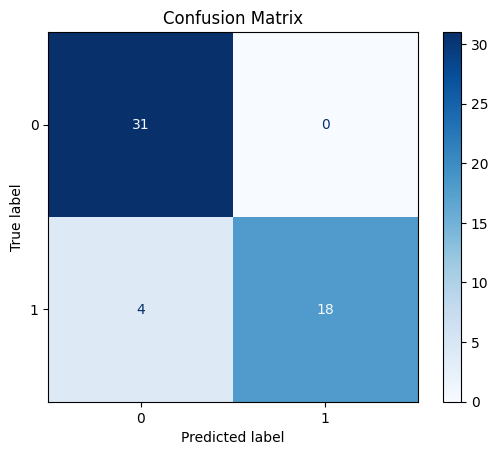

In [42]:
print("\n Classification Report: \n" , classification_report(y_test,  best2.predict(X_test)))

import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")    
plt.title("Confusion Matrix")
plt.show()

Class 0 (Healthy)

Recall = 1.00: Identified 100% of healthy individuals (no false alarms for Class 0; all 31 were caught).

Precision = 0.89: When the model predicts “0”, 89% of those predictions are actually 0 (this drops because there are 4 false alarms from Class 1, which turned into predictions of 0).

F1 = 0.94: Very good and stable performance for Class 0.

Class 1 (Patient)

Precision = 1.00: Every time the model predicted “1”, it was correct (FP = 0). That is, zero false alarms.

Recall = 0.82: Detected 82% of patients; missed 18% (the 4 cases classified as 0).

F1 = 0.90: Good performance, with the main limitation being sensitivity (recall).

Accuracy = 0.92

92% overall accuracy on the test (consistent with 49 correct answers out of 53).

Macro average (0.94 / 0.91 / 0.92)

Average "per class" (each class weights equally). Shows that the model is well balanced, but class 1 has lower recall.

Weighted average (0.93 / 0.92 / 0.92)

Weighted average by support (weight proportional to the number of examples). As there are slightly more 0s than 1s, it accurately reflects overall performance.

Summary in one sentence: the model is very strong at avoiding false positives (precision of class 1 = 1.00), but still misses some patients (recall of class 1 = 0.82, 4

Final Conclusion After Classification Report

The final model demonstrates excellent generalization capacity, confirmed by consistent metrics across cross-validation, test accuracy, and classification report.

Key points:

High overall performance: Accuracy = 0.92, indicating that the model correctly predicts the vast majority of cases in the test set.

Class 0 (no disease): virtually perfect recall performance (1.00), meaning no false negatives for healthy patients.

Class 1 (with disease):

Precision = 1.00 → when the model predicts disease, it does not err (zero false positives).

Recall = 0.82 → there are still some undetected cases of disease, which is the main point of clinical attention.

High F1 score in both classes (0.94 and 0.90), showing a good balance between precision and sensitivity.

The macro and weighted averages reinforce that the model is stable and unbiased by imbalance. Practical Interpretation (Important)

The model is conservative:

It prefers not to diagnose disease rather than generate false alarms.

When you say there is disease, the prediction is highly reliable.

In a clinical context, this is suitable as a decision support model, but it may be interesting in the future to increase the recall of class 1 if the goal is more sensitive screening.

📌 Final Conclusion:

The model is validated, robust, and ready for predictive use, with well-understood behavior and clearly mapped risks.

# 10. Forecast for new patient (fictitious average values)

In [44]:
novo_patient = pd.DataFrame([{
    'age': 55, 'trestbps': 130, 'chol': 245, 'thalach': 150,
    'oldpeak': 1.0, 'ca': 0, 'sex': 1, 'cp': 1, 'fbs': 0,
    'restecg': 1, 'exang': 0, 'slope': 2,
    'thal': 2
}])


#pred_novo = grid.predict(novo_patient)
pred_novo = best2.predict(novo_patient)
print(f"\n Predicted risk for new patient: {'Patient Sick' if pred_novo[0] == 1 else 'Healthy'}")


 Predicted risk for new patient: Healthy
